<a href="https://colab.research.google.com/github/vitroid/PythonTutorials/blob/2020m1/k_means%E3%81%AB%E3%82%88%E3%82%8B%E5%86%99%E7%9C%9F%E3%81%AE%E6%B8%9B%E8%89%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 写真の減色

k-meansを使って代表的な色を割り出す。

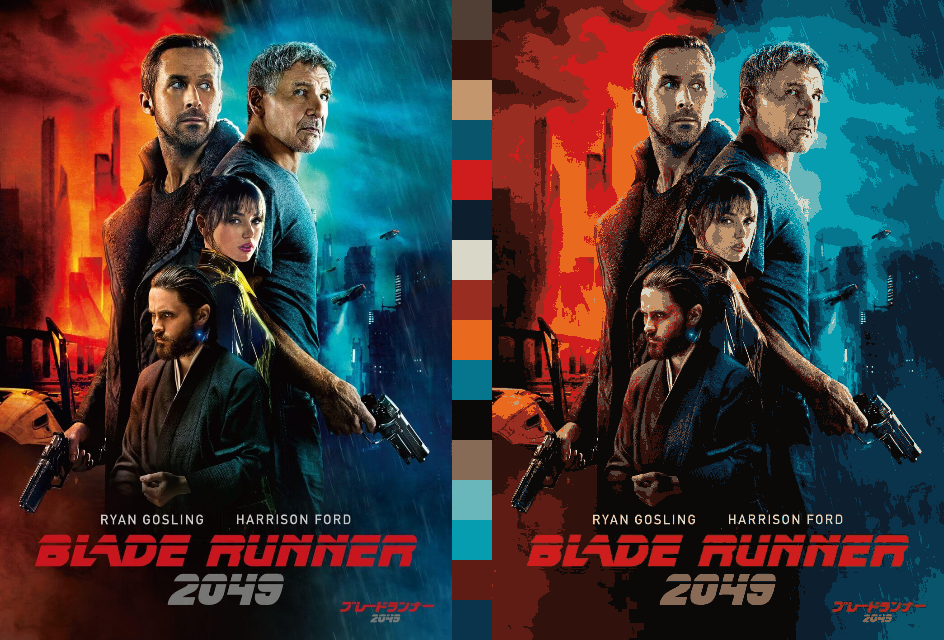

In [48]:
# Pythonデータサイエンスハンドブック 5.11.1
from sklearn.cluster import KMeans
import numpy as np

def color_reduction(img, Ncolor):

    height, width = img.shape[:2]
    Npix = height*width

    #画像をピクセル列に変換する(そうしないとk-meansが使えない)
    pixels = img.reshape(Npix, 3)

    # 8つの代表的な色をさがさせる。
    kmeans = KMeans(n_clusters=Ncolor, max_iter=1000)
    kmeans.fit(pixels)

    # それぞれのピクセルに一番近い中心は何番か。
    new_pixels = kmeans.cluster_centers_[kmeans.predict(pixels)]

    # new_pixelsを8ビット整数にし、arrayの形をもとに戻す。
    reduced = new_pixels.astype(np.uint8).reshape(height, width, 3)
    return reduced, kmeans.cluster_centers_


from imageio import imread
import PIL
import cv2

thumbsize = 640
img = imread("https://www.sonypictures.jp/sites/default/files/styles/keyart_large/public/2018-06/2210060.jpg?itok=lvR6uRxP")
#img = imread("https://hips.hearstapps.com/jp.h-cdn.co/harpersbazaarjp/harpersbazaar-mig/images/celebrity/annehathaway-beauty-181116-hns/14/373570-3-jpn-JP/2018-35.jpg")
height, width = img.shape[:2]
if height > width:
    scale = thumbsize/height
else:
    scale = thumbsize/width
newsize = (int(width*scale), int(height*scale))
img = cv2.resize(img, newsize)
#display(PIL.Image.fromarray(resized))


Ncolor=16
reduced, colors = color_reduction(img, Ncolor)
# 代表色を並べる
sqsize = newsize[1] // Ncolor
squares = np.zeros([newsize[1],sqsize,3])
for i in range(Ncolor):
    squares[i*sqsize:(i+1)*sqsize,:] = colors[i]
## display(PIL.Image.fromarray(squares.astype(np.uint8)))


# 貼りあわせて1枚にする。
newsize = [img.shape[0], img.shape[1]+sqsize+reduced.shape[1], 3]
panel = np.zeros(newsize, dtype=np.uint8)
panel[:, 0:img.shape[1]] = img
panel[:squares.shape[0], img.shape[1]:img.shape[1]+sqsize] = squares
panel[:, img.shape[1]+sqsize:] = reduced

display(PIL.Image.fromarray(panel))